In [1]:
import os
from torchvision import datasets
from torch.utils.data import DataLoader
import torch.nn as nn
import torch
from torch.autograd import Variable
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from PIL import Image
import torchvision.utils as vutils
%matplotlib inline

In [2]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()

## 데이터 로딩

In [3]:
img_size = 64
batch_size=64
lr = 0.0002
beta1 = 0.5
niter= 25
outf= 'output'

dataset = datasets.CIFAR10( root = 'data',download=True,
                       transform=transforms.Compose([
                           transforms.Resize(img_size),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                       ]))
dataloader = torch.utils.data.DataLoader(dataset, batch_size,
                                         shuffle=True)


In [4]:
#Size of latnet vector
nz = 100
# Filter size of generator
ngf = 64
# Filter size of discriminator
ndf = 64
# Output image channels
nc = 3

# 네트워크 초기화

In [5]:
# custom weights initialization called on netG and netD
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

# 생성기

In [6]:
class _netG(nn.Module):
    def __init__(self):
        super(_netG, self).__init__()

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. (ngf*8) x 4 x 4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 8 x 8
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 16 x 16
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 32 x 32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. (nc) x 64 x 64
        )

    def forward(self, input):
        output = self.main(input)
        return output


netG = _netG()
netG.apply(weights_init)
print(netG)

_netG(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


# 판별기

In [7]:
class _netD(nn.Module):
    def __init__(self):
        super(_netD, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 64 x 64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 32 x 32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 16 x 16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 8 x 8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 4 x 4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        output = self.main(input)
        return output.view(-1, 1).squeeze(1)


netD = _netD()
netD.apply(weights_init)
print(netD)

_netD(
  (main): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


# 오차 함수 정의

In [8]:
criterion = nn.BCELoss()

input = torch.FloatTensor(batch_size, 3, img_size, img_size)
noise = torch.FloatTensor(batch_size, nz, 1, 1)
fixed_noise = torch.FloatTensor(batch_size, nz, 1, 1).normal_(0, 1)
label = torch.FloatTensor(batch_size)
real_label = 1
fake_label = 0

In [9]:
if torch.cuda.is_available():
    netD.cuda()
    netG.cuda()
    criterion.cuda()
    input, label = input.cuda(), label.cuda()
    noise, fixed_noise = noise.cuda(), fixed_noise.cuda()

# 옵티마이저 정의

In [10]:
fixed_noise = Variable(fixed_noise)

# setup optimizer
optimizerD = optim.Adam(netD.parameters(), lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr, betas=(beta1, 0.999))

# 학습 

In [12]:
%%time
for epoch in range(niter):
    for i, data in enumerate(dataloader, 0):
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        # train with real
        netD.zero_grad()
        real_cpu, _ = data
        batch_size = real_cpu.size(0)
        if torch.cuda.is_available():
            real_cpu = real_cpu.cuda()
        input.resize_as_(real_cpu).copy_(real_cpu)
        label.resize_(batch_size).fill_(real_label)
        inputv = Variable(input)
        labelv = Variable(label)

        output = netD(inputv)
        errD_real = criterion(output, labelv)
        errD_real.backward()
        D_x = output.data.mean()

        # train with fake
        noise.resize_(batch_size, nz, 1, 1).normal_(0, 1)
        noisev = Variable(noise)
        fake = netG(noisev)
        labelv = Variable(label.fill_(fake_label))
        output = netD(fake.detach())
        errD_fake = criterion(output, labelv)
        errD_fake.backward()
        D_G_z1 = output.data.mean()
        errD = errD_real + errD_fake
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        labelv = Variable(label.fill_(real_label))  # fake labels are real for generator cost
        output = netD(fake)
        errG = criterion(output, labelv)
        errG.backward()
        D_G_z2 = output.data.mean()
        optimizerG.step()
        
        
        if i % 100 == 0:
            print('[%d/%d][%d/%d] Loss_D: %.4f Loss_G: %.4f D(x): %.4f D(G(z)): %.4f / %.4f'
                  % (epoch, niter, i, len(dataloader), errD.data.item(), errG.data.item(), D_x, D_G_z1, D_G_z2))
            
            vutils.save_image(real_cpu, '%s/real_samples.png' % outf, normalize=True)
            fake = netG(fixed_noise)
            vutils.save_image(fake.data, '%s/fake_samples_epoch_%03d.png' % (outf, epoch), normalize=True)

[0/25][0/782] Loss_D: 1.1948 Loss_G: 6.1791 D(x): 0.7326 D(G(z)): 0.5003 / 0.0031
[0/25][100/782] Loss_D: 0.2966 Loss_G: 5.9547 D(x): 0.8067 D(G(z)): 0.0013 / 0.0068
[0/25][200/782] Loss_D: 0.1578 Loss_G: 5.6523 D(x): 0.8914 D(G(z)): 0.0226 / 0.0049
[0/25][300/782] Loss_D: 0.4062 Loss_G: 3.8230 D(x): 0.7934 D(G(z)): 0.0922 / 0.0668
[0/25][400/782] Loss_D: 0.7445 Loss_G: 3.8513 D(x): 0.5934 D(G(z)): 0.0344 / 0.0301
[0/25][500/782] Loss_D: 0.3892 Loss_G: 5.0896 D(x): 0.7910 D(G(z)): 0.1003 / 0.0105
[0/25][600/782] Loss_D: 0.1856 Loss_G: 6.1055 D(x): 0.8762 D(G(z)): 0.0147 / 0.0037
[0/25][700/782] Loss_D: 0.9569 Loss_G: 7.4894 D(x): 0.5227 D(G(z)): 0.0052 / 0.0029
[1/25][0/782] Loss_D: 0.4258 Loss_G: 5.8250 D(x): 0.9353 D(G(z)): 0.2459 / 0.0058
[1/25][100/782] Loss_D: 0.1838 Loss_G: 4.1453 D(x): 0.9013 D(G(z)): 0.0671 / 0.0207
[1/25][200/782] Loss_D: 0.2222 Loss_G: 4.7376 D(x): 0.8504 D(G(z)): 0.0403 / 0.0182
[1/25][300/782] Loss_D: 0.7677 Loss_G: 3.4264 D(x): 0.6009 D(G(z)): 0.0731 / 0.0

In [13]:
!ls -al output/

합계 12652
drwxrwxr-x  2 taeho taeho   4096  3월 10 17:54 .
drwxrwxr-x 16 taeho taeho   4096  3월 10 20:16 ..
-rw-rw-r--  1 taeho taeho 562144  3월 10 17:13 fake_samples_epoch_000.png
-rw-rw-r--  1 taeho taeho 495982  3월 10 17:15 fake_samples_epoch_001.png
-rw-rw-r--  1 taeho taeho 490946  3월 10 17:16 fake_samples_epoch_002.png
-rw-rw-r--  1 taeho taeho 470138  3월 10 17:17 fake_samples_epoch_003.png
-rw-rw-r--  1 taeho taeho 451710  3월 10 17:19 fake_samples_epoch_004.png
-rw-rw-r--  1 taeho taeho 453606  3월 10 17:20 fake_samples_epoch_005.png
-rw-rw-r--  1 taeho taeho 455015  3월 10 17:21 fake_samples_epoch_006.png
-rw-rw-r--  1 taeho taeho 452386  3월 10 17:23 fake_samples_epoch_007.png
-rw-rw-r--  1 taeho taeho 437945  3월 10 17:24 fake_samples_epoch_008.png
-rw-rw-r--  1 taeho taeho 443312  3월 10 17:25 fake_samples_epoch_009.png
-rw-rw-r--  1 taeho taeho 445010  3월 10 17:27 fake_samples_epoch_010.png
-rw-rw-r--  1 taeho taeho 459867  3월 10 17:28 fake_samples_epoch_011.png
-rw-rw-r--  1 taeh

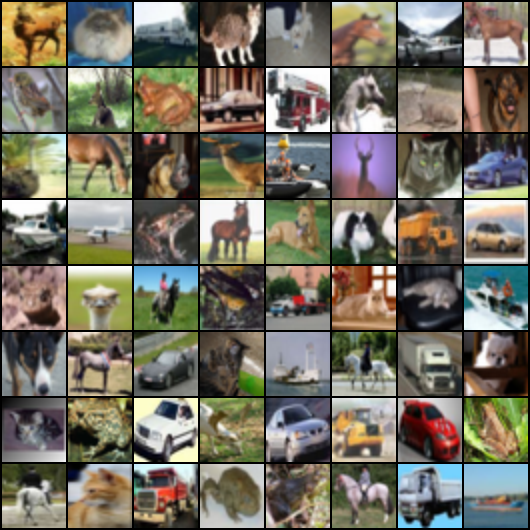

In [14]:
Image.open('output/real_samples.png')

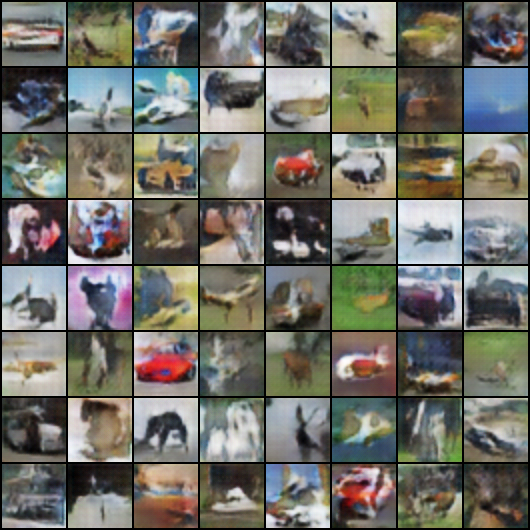

In [16]:
Image.open('output/fake_samples_epoch_018.png')